### Step 6. 딥러닝 구현

# LSTM 모델 이용 (2)
4_Deep_Learning(4) 파일에서는 LSTM 모델을 이용하여 학습을 시킬 것입니다. 4_Deep_Learning(1)에서 진행한 모델을 수정할 것입니다.

### 학습 전 데이터 가져오기
4_Deep_Learning_(1)과 동일한 과정을 거치는 것이기 때문에 하나의 셀에 모두 적었습니다. 

In [1]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
csvs = ["발라드", "랩힙합", "트로트", "CCM"]

def csv_data() :
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    f = open('4_Refined Dataset.csv','r', encoding='utf-8')
    rdr = csv.reader(f)
    for line in rdr:
        data = []
        if line[-1] == 'type' : continue
        elif line[-1] == 'train' :
            for i in range(1,len(line)-2) :
                data.append(int(line[i]))
            x_train.append(data)
            y_train.append(int(line[-2]))
        elif line[-1] == 'test' :
            for i in range(1,len(line)-2) :
                data.append(int(line[i]))
            x_test.append(data)
            y_test.append(int(line[-2]))
    f.close()
    
    # 학습 데이터 정보 출력
    print("train 데이터 수 :", len(x_train))
    for k in range(len(csvs)) :
        print(csvs[k] + " :", len([i for i in y_train if i == k]))
    print("----------------")
    print("test 데이터 수 :", len(x_test))
    for k in range(len(csvs)) :
        print(csvs[k] + " :", len([i for i in y_test if i == k]))
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = csv_data()

max_val_lists = []
for i in x_train :
    max_val_lists.append(max(i))
num_input = max(max_val_lists) + 1

train_tuple_lists = []
for i in range(len(x_train)) :
    train_tuple_lists.append((x_train[i], y_train[i]))
random.shuffle(train_tuple_lists)
x_train = [i[0] for i in train_tuple_lists]
y_train = [i[1] for i in train_tuple_lists]

e = LabelEncoder()
e.fit(y_train)
Y = e.transform(y_train)
y_train = tf.keras.utils.to_categorical(Y) 
print("training 데이터 수 :", len(y_train))

e = LabelEncoder()
e.fit(y_test)
Y = e.transform(y_test)
y_test = tf.keras.utils.to_categorical(Y) 
print("test 데이터 수 :", len(y_test))

print("원 핫 인코딩된 y_train 예시\n", y_train[:3])

train 데이터 수 : 3216
발라드 : 804
랩힙합 : 804
트로트 : 804
CCM : 804
----------------
test 데이터 수 : 804
발라드 : 201
랩힙합 : 201
트로트 : 201
CCM : 201
training 데이터 수 : 3216
test 데이터 수 : 804
원 핫 인코딩된 y_train 예시
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


## 모델 학습

#### 학습(training)

In [4]:
class LSTM_2_model : # k fold에서 모델을 여러번 이용할 것이기 때문에 사용하기 쉽도록 class로 만들었습니다.
    def __init__(self) : # 모델 설계 및 컴파일
        self.model = Sequential()
        self.model.add(Embedding(num_input, 20))
        self.model.add(LSTM(32))
        self.model.add(Dense(32))
        self.model.add(Dense(16))
        self.model.add(Dense(len(csvs), activation='softmax'))
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    def learn(self, x, y, save) : # 모델 학습
        # save : 1이면 모델 저장을 합니다
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
        if save == 1 :
            mc = ModelCheckpoint('LSTM_2_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
            self.history = self.model.fit(x, y, epochs=30, callbacks=[es, mc], batch_size=64, validation_split=0.2)
        else :
            self.history = self.model.fit(x, y, epochs=30, callbacks=[es], batch_size=64, validation_split=0.2)
    def graph(self) : # 그래프 그리기
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['loss'])
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['val_loss'])
        plt.title('loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.show()
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['acc'])
        plt.plot(range(1, len(self.history.history['acc']) + 1), self.history.history['val_acc'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'])
        plt.show()
    def test(self, x, y) : # 모델 테스트
        loaded_model = load_model('LSTM_2_model.h5')
        p = (loaded_model.evaluate(x, y))
        print("\n 테스트 loss값: %.4f" % p[0])
        print("\n 테스트 정확도: %.4f" % p[1])
    def return_test_acc(self, x, y) :
        return self.model.evaluate(x, y)

In [5]:
A = LSTM_2_model()
print(A.model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          148300    
                                                                 
 lstm (LSTM)                 (None, 32)                6784      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 156,736
Trainable params: 156,736
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
A.learn(np.array(x_train), y_train, 1) 

Epoch 1/30
41/41 [==============================] - ETA: 0s - loss: 1.3391 - acc: 0.3281
Epoch 1: val_acc improved from -inf to 0.49068, saving model to LSTM_2_model.h5
41/41 [==============================] - 5s 89ms/step - loss: 1.3391 - acc: 0.3281 - val_loss: 1.0272 - val_acc: 0.4907
Epoch 2/30
41/41 [==============================] - ETA: 0s - loss: 0.9440 - acc: 0.5043
Epoch 2: val_acc improved from 0.49068 to 0.50311, saving model to LSTM_2_model.h5
41/41 [==============================] - 3s 80ms/step - loss: 0.9440 - acc: 0.5043 - val_loss: 0.9697 - val_acc: 0.5031
Epoch 3/30
41/41 [==============================] - ETA: 0s - loss: 0.8138 - acc: 0.5918
Epoch 3: val_acc improved from 0.50311 to 0.59006, saving model to LSTM_2_model.h5
41/41 [==============================] - 3s 79ms/step - loss: 0.8138 - acc: 0.5918 - val_loss: 0.9140 - val_acc: 0.5901
Epoch 4/30
41/41 [==============================] - ETA: 0s - loss: 0.6859 - acc: 0.6913
Epoch 4: val_acc improved from 0.59006

#### 시각화

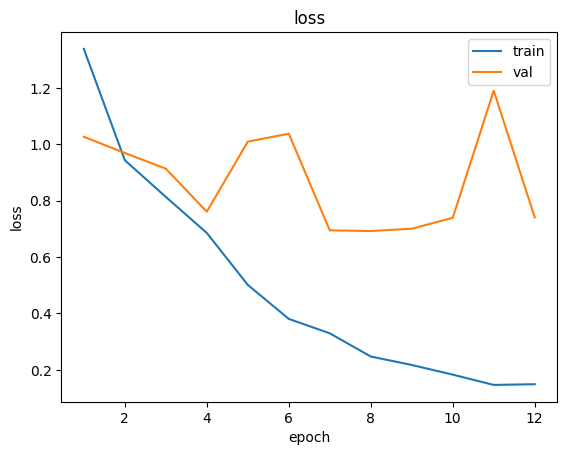

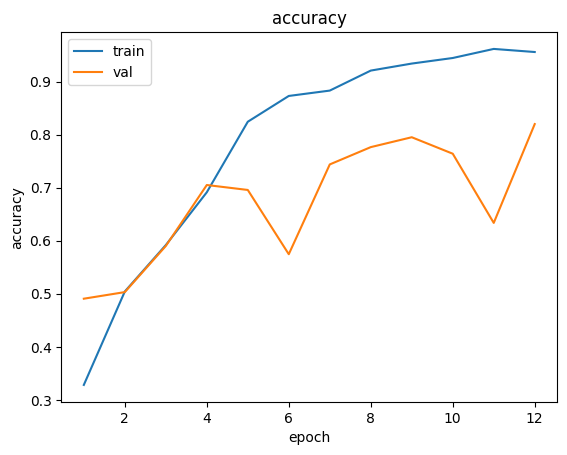

In [7]:
A.graph()

#### 평가(test)

In [9]:
A.test(np.array(x_test), y_test)

26/26 [==============================] - 1s 20ms/step - loss: 0.6428 - acc: 0.8246

 테스트 loss값: 0.6428

 테스트 정확도: 0.8246


#### 데이터셋에 없는 가사 예측
데이터셋에 없는 가사를 받아 예측하기 위해서는 데이터 정제, 가공 과정이 다시 필요합니다. 따라서 4_Dataset Processing 과정을 반복하여 tokenizer을 얻도록 했습니다. 한번 더 작성하는 대신 processing.py형태로 만들어서 가져와 사용했습니다.

In [10]:
import processing # processing.py
import re
from konlpy.tag import Okt
tokenizer = processing.processing(num_input)

def pred(data) :
    data = data.replace("\n", " ")
    data = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',"", data)
    okt = Okt()
    data = okt.morphs(data, stem=True)
    data = tokenizer.texts_to_sequences([data])
    print("예측 : " + csvs[int(np.argmax(A.model.predict(data, verbose=0), axis=-1))])

위의 pred()함수를 이용해 예측할 수 있습니다. 가사를 그대로 가져와 아래의 변수 a에 넣은 후 pred(a)로 예측했습니다.

In [11]:
# 데이터셋에 없는 노래를 가져왔습니다. (정답 : 발라드)
a = '''이제 괜찮냐 묻지 않네요
이젠 내가 짐이 된 걸까요
멍든 내 마음이 가여워서
우습게 우리의 과거를 바래봐요
우리 만일에 마주하더라도
아무 말 없이 지나가요
그렇게 날 쳐다보지 말아요
그대 제발
더 이상 나 괴로워하지 않아요
그댄 날 잊었는데
그대도 해냈는데
나라고 못할 거 있나요
멍든 내 마음이 가여워서
이제는 우리의 과거를 지워가요
우리 만일에 마주하더라도
아무 말 없이 지나가요
그렇게 날 쳐다보지 말아요
그대 제발
더 이상 나 괴로워하지 않아요
그댄 날 잊었는데
그대도 해냈는데
나라고 못할 거 있나요
괴로워하지 않아요
그댄 날 잊었는데
그대도 해냈는데
나라고 못할 거 있나요'''

pred(a)

예측 : 발라드


In [12]:
# 데이터셋에 없는 노래를 가져왔습니다. (정답 : 랩힙합)
a = '''I know it`s your time 
그런데도 너에게 간데
아마 위험한
대가는 나에게만 왜 (why)
이유가 대체 넌
뭐라 생각해?
아마 이건 참
알아도 잠시 길을 잃어 way
어제는 저기가 main
오늘은 여기로 해
네가 날 어지럽게
하는지 모르겠어 잠시 wait
귀가를 하기로 해
조금은 쉬기로 해
내가 원하는 뭘 하든
내 시간을 제발 좀 갖기로 해
반복해 너를 표현해 All day
피해자래 난 그저 웃어
The word doesn't suit you babe
아무 말도 하지마
덧붙여 말을 해
You're really so bad
난 그저 웃겨
The word
doesn't suit you babe
아무 말도 하지마 하지마
그건 아닐 거야
네가 굉장히 오해가 많아
내가 친절하게
설명해도
yeah 안 들어줘 sh*t!
너에겐 자비롭고
그런 걸 바라는 내가 참
한심해 보이며 어이없어
Next time 다음 시간을
기약하며 날 뒤로 휙
던져 버린 후에 잠시 놓기
오후 지나 밤에 다시 줍기
이런 사실을 넌 알 리 없지
노래로 처음 접하게 될 일
조금은 아쉽겠지만 뭐 어떻게
이미 다른 차에 타 있으니
네가 피해자래도
입장을 바꿔 말해줘
근데 넌 절대 모르겠지
평생을 제발 그렇겠니
반복해 너를 표현해 All day
피해자래 난 그저 웃어
The word doesn't suit you babe
아무 말도 하지마
덧붙여 말을 해
You're really so bad 난 그저 웃겨
The word doesn't suit you babe
아무 말도 하지마 하지마'''

pred(a)

예측 : 랩힙합


### 다른 모델들과 비교

#### k-fold cross validation
다른 모델들과 비교하기 위해서는 k-fold를 이용해 산출한 평균 정확도를 비교하는 것이 필요하다고 생각했습니다. k fold에 이용되는 데이터 셋으로는 위에서의 x_train을 나누어 train, test 데이터로 만들어 이용했습니다.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


def start_kfold(X, y) :
    kf = KFold(n_splits = 5, shuffle = True, random_state = 50)
    accuracy_history = []
    loss_history = []
    num = 0
    models = []
    for train_index, test_index in kf.split(X):
        num += 1
        print("--------------" + str(num) + "번째 그룹" + "----------------")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        B = LSTM_2_model()
        B.learn(X_train, y_train, 0)
        accuracy_history.append(B.return_test_acc(X_test, y_test)[1]) # 정확도 측정 및 기록
        loss_history.append(B.return_test_acc(X_test, y_test)[0])
    print("-----------------------------------------")
    print("------------------결과-------------------")
    print("-----------------------------------------")
    print("각 분할의 loss :", accuracy_history)
    print("평균 loss :", np.mean(accuracy_history))
    print("각 분할의 정확도 :", accuracy_history)
    print("평균 정확도 :", np.mean(accuracy_history)*100, "%")
    
    
start_kfold(np.array(x_train), y_train)

--------------1번째 그룹----------------
Epoch 1/30
33/33 [==============================] - 4s 82ms/step - loss: 1.3719 - acc: 0.3111 - val_loss: 1.2357 - val_acc: 0.4602
Epoch 2/30
33/33 [==============================] - 2s 64ms/step - loss: 1.0270 - acc: 0.4823 - val_loss: 0.9917 - val_acc: 0.4718
Epoch 3/30
33/33 [==============================] - 2s 67ms/step - loss: 0.8781 - acc: 0.5523 - val_loss: 0.9489 - val_acc: 0.5592
Epoch 4/30
33/33 [==============================] - 2s 69ms/step - loss: 0.8134 - acc: 0.6125 - val_loss: 0.9193 - val_acc: 0.5592
Epoch 5/30
33/33 [==============================] - 2s 70ms/step - loss: 0.6949 - acc: 0.6952 - val_loss: 1.4132 - val_acc: 0.5010
Epoch 6/30
33/33 [==============================] - 2s 71ms/step - loss: 0.5525 - acc: 0.7560 - val_loss: 1.0976 - val_acc: 0.6058
Epoch 7/30
33/33 [==============================] - 2s 68ms/step - loss: 0.4852 - acc: 0.7710 - val_loss: 0.8674 - val_acc: 0.6311
Epoch 8/30
33/33 [============================

33/33 [==============================] - 3s 87ms/step - loss: 0.1276 - acc: 0.9650 - val_loss: 0.7487 - val_acc: 0.8097
Epoch 11/30
33/33 [==============================] - 3s 81ms/step - loss: 0.0913 - acc: 0.9723 - val_loss: 0.8465 - val_acc: 0.8058
Epoch 12/30
33/33 [==============================] - 3s 87ms/step - loss: 0.0671 - acc: 0.9835 - val_loss: 0.9599 - val_acc: 0.7942
Epoch 12: early stopping
21/21 [==============================] - 0s 22ms/step - loss: 0.9154 - acc: 0.7885
-----------------------------------------
------------------결과-------------------
-----------------------------------------
각 분할의 loss : [0.782608687877655, 0.7122861742973328, 0.7947123050689697, 0.7698289155960083, 0.788491427898407]
평균 loss : 0.7695855021476745
각 분할의 정확도 : [0.782608687877655, 0.7122861742973328, 0.7947123050689697, 0.7698289155960083, 0.788491427898407]
평균 정확도 : 76.95855021476746 %


k-fold를 이용해 구한 loss값은 [0.782608687877655, 0.7122861742973328, 0.7947123050689697, 0.7698289155960083, 0.788491427898407]로 평균 0.77입니다. 정확도는 [0.782608687877655, 0.7122861742973328, 0.7947123050689697, 0.7698289155960083, 0.788491427898407]으로 평균 76.96%입니다. 

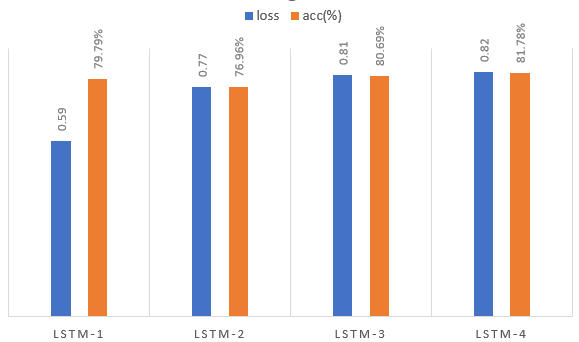

본 모델(LSTM-2)은 4_Deep Learning_(1) 모델에 두개의 Dense 층을 쌓은 형태입니다. 기존의 LSTM-1모델보다 정확도가 떨어졌습니다. 저는 이 현상이 모델이 복잡해져서 train 데이터에 대하여만 과도하게 학습해 생기는 과적합이라고 생각합니다. 